#  Forecasting the number of sold for Indian spices  
We will forecast the number of sold goods in the city of Bangalore (India)

## 1. Подготовительный этап

### 1.1 Импорт библиотек, данных

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from etna.pipeline import Pipeline
from etna.metrics import R2
from etna.analysis import plot_forecast, plot_backtest
from etna.transforms import STLTransform, LagTransform, MeanSegmentEncoderTransform
from etna.datasets.tsdataset import TSDataset
from etna.models import NaiveModel, CatBoostMultiSegmentModel, LinearPerSegmentModel, SARIMAXModel

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

/home/mub/miniconda3/envs/etna_py310/lib/python3.10/site-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/home/mub/miniconda3/envs/etna_py310/lib/python3.10/site-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/home/mub/miniconda3/envs/etna_py310/lib/python3.10/site-packages/etna/settings.py:53: UserWarning: etna[prophet] is not available, to install it, run `pip install etna[prophet]`
  warnings.warn("etna[prophet] is not available, to install it, run `pip install etna[prophet]`")
/home/mub/miniconda3/envs/etna_py310/lib/python3.10/site-packages/etna/settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  wa

In [2]:
# sales data in India in various cities and states
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")

df.date = pd.DatetimeIndex(df.date)

# sort and add date to the index
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")

In [3]:
# we need only 'quantity' column, drop another
df_bang = df.loc[df.city == "BANGALORE"].copy()

# df_bang column's names convert to drop list
drop_list = list(df_bang.columns)
drop_list.remove('quantity')
print(drop_list)

# drop columns
ts = df_bang.drop(drop_list, axis=1)
ts_clean = pd.DataFrame(ts.copy())

ts.head()

['market', 'month', 'year', 'priceMin', 'priceMax', 'priceMod', 'state', 'city', 'date']


,quantity
date,
2004-01,227832
2004-02,225133
2004-03,221952
2004-04,185150
2004-05,137390


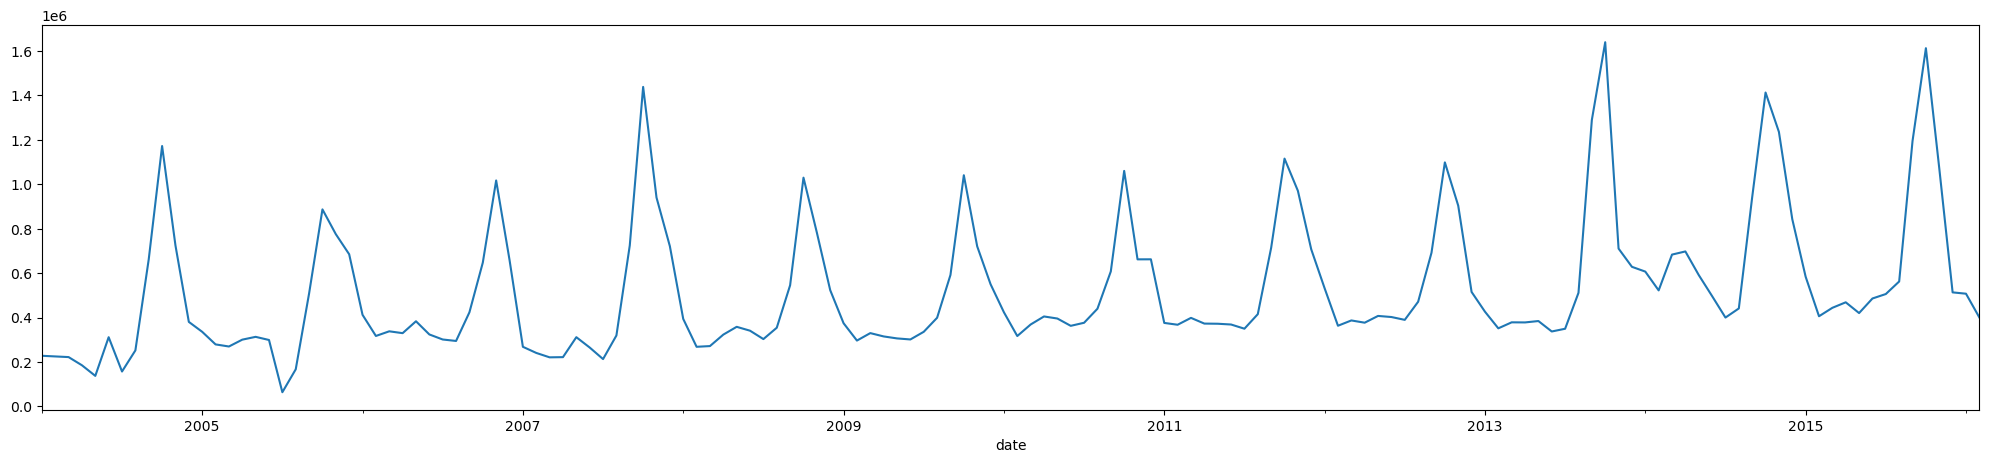

In [4]:
ts.quantity.plot(figsize=(25,5));

## 2. Data preprocessing

### 2.1 Create new TS features

In [5]:
# add lag features at first
for i in range(1, 8):
    ts[f'lag_{i}'] = ts.quantity.shift(i)

ts.dropna(inplace=True)
    
print(ts[1:12])

         quantity      lag_1      lag_2      lag_3      lag_4      lag_5  \
date                                                                       
2004-09    662382   251984.0   157022.0   311445.0   137390.0   185150.0   
2004-10   1171846   662382.0   251984.0   157022.0   311445.0   137390.0   
2004-11    724140  1171846.0   662382.0   251984.0   157022.0   311445.0   
2004-12    380379   724140.0  1171846.0   662382.0   251984.0   157022.0   
2005-01    335679   380379.0   724140.0  1171846.0   662382.0   251984.0   
2005-02    279047   335679.0   380379.0   724140.0  1171846.0   662382.0   
2005-03    269609   279047.0   335679.0   380379.0   724140.0  1171846.0   
2005-04    300428   269609.0   279047.0   335679.0   380379.0   724140.0   
2005-05    313052   300428.0   269609.0   279047.0   335679.0   380379.0   
2005-06    298906   313052.0   300428.0   269609.0   279047.0   335679.0   
2005-07     63824   298906.0   313052.0   300428.0   269609.0   279047.0   

           

### 2.2 Split train & test df

In [6]:
# split train and test
split_index = int(0.85*len(ts))

train = ts[:split_index]
test = ts[split_index:]

print(f'Train shape is {train.shape} and test shape is {test.shape}')

Train shape is (118, 8) and test shape is (21, 8)


In [7]:
# stand out X y
y_train = train['quantity']
y_test = test['quantity']

X_train = train.drop('quantity', axis=1)
X_test = test.drop('quantity', axis=1)

### 2.3 Create agregating features

Previously I used pivot tables to create aggregate attributes like average for the day, but now I found a way to do it more laconic.

In [8]:
# func create the dictionary with key - feature name, value - aggregated feature;
# so we can choose any categorical feature and apply to it some aggregation func;
# above we use it for mean value
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [9]:
# check it on month mean
ts['month'] = ts.index.month
mean_dict = code_mean(ts,'month','quantity')

display(mean_dict)

{1: 436629.0833333333,
 2: 344012.0,
 3: 371731.36363636365,
 4: 380720.8181818182,
 5: 385653.45454545453,
 6: 362042.2727272727,
 7: 326113.2727272727,
 8: 385456.6666666667,
 9: 741183.9166666666,
 10: 1179204.8333333333,
 11: 876030.3333333334,
 12: 615578.75}

## 3.0 Baseline

CPU times: user 9.9 ms, sys: 0 ns, total: 9.9 ms
Wall time: 9.53 ms


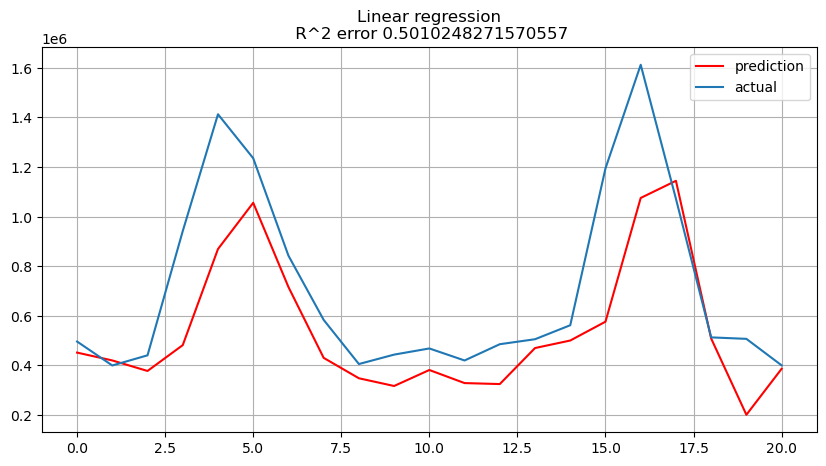

In [10]:
%%time

# declare the regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.grid(True)
plt.legend(loc='best')
plt.title(f'Linear regression\n R^2 error {r2_score(y_test,y_pred)}');

## 4. Model improvement

### 4.1 Add the average for the month

In [11]:
"""
In common case it will be:
ts['month_avg'] = list(map(code_mean(ts, 'month', 'quantity').get, ts.month))

1) split_index will prevent future data leaks;
2) get method method returns the value of the item with the specified key;
3) map applies code_mean func to ts.month;
"""

ts['month_avg'] = list(map(code_mean(ts.iloc[:split_index], 'month', 'quantity').get, ts.month))
ts.head()

,quantity,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,month,month_avg
date,,,,,,,,,,
2004-08,251984,157022.0,311445.0,137390.0,185150.0,221952.0,225133.0,227832.0,8,362241.8
2004-09,662382,251984.0,157022.0,311445.0,137390.0,185150.0,221952.0,225133.0,9,675778.1
2004-10,1171846,662382.0,251984.0,157022.0,311445.0,137390.0,185150.0,221952.0,10,1112561.2
2004-11,724140,1171846.0,662382.0,251984.0,157022.0,311445.0,137390.0,185150.0,11,820510.3
2004-12,380379,724140.0,1171846.0,662382.0,251984.0,157022.0,311445.0,137390.0,12,603110.6


### 4.2 Create special function for data preprocessing

In [12]:
def preprocess_data(data, lag_start=1, lag_end=8, split_index=split_index):
    data = pd.DataFrame(data.copy())

    for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = data['quantity'].shift(i)

    data = data.dropna()

    data['month'] = data.index.month

    data['month_avg'] = list(map(code_mean(data.iloc[:split_index], 'month', 'quantity').get, data.month))

    # name of the month we don't need any more, drop it
    data.drop(['month'], axis=1, inplace=True)
    
    # take two df for future
    train_df = data.iloc[:split_index]
    train_df.reset_index(inplace=True)
    test_df = data.iloc[split_index:]
    test_df.reset_index(inplace=True)

    # split the dataset to train and test
    X_train = data.iloc[:split_index].drop(['quantity'], axis=1)
    y_train = data.iloc[:split_index]['quantity']
    X_test = data.iloc[split_index:].drop(['quantity'], axis=1)
    y_test = data.iloc[split_index:]['quantity']

    return X_train, X_test, y_train, y_test, train_df, test_df

In [13]:
X_train, X_test, y_train, y_test, train_df, test_df = preprocess_data(ts_clean,1,12)

X_train.shape, X_test.shape

((118, 12), (17, 12))

### 4.3 Check the R^2 result

CPU times: user 9.68 ms, sys: 1.17 ms, total: 10.8 ms
Wall time: 9.94 ms


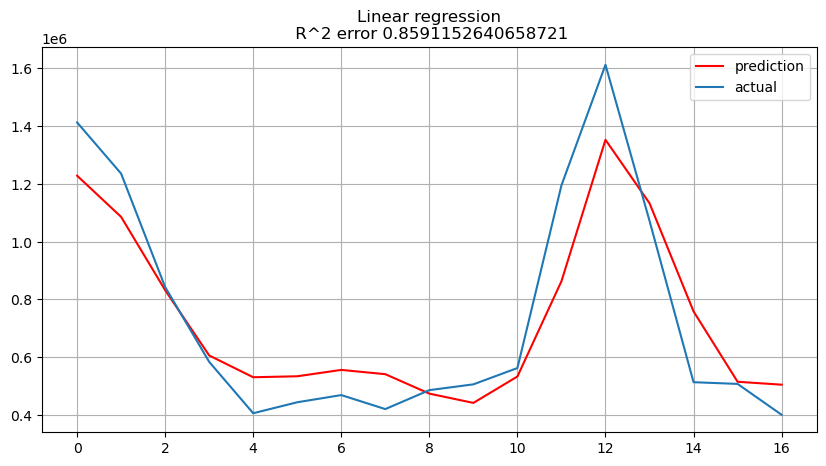

In [14]:
%%time

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.grid(True)
plt.legend(loc='best')
plt.title(f'Linear regression\n R^2 error {r2_score(y_test,y_pred)}');

## 5. Try to use the ETNA library

The ETNA library was already installed in a virtual environment, if you execute the code in colab, you can use the command below:  
#!pip install etna -q

Note that at the time of writing the project the library supported Python <= 3.10, although 3.12 was already on the market.

We need to convert our existing data into the ETNA library format:  
* column `timestamp` - time at datetime format;  
* column `target` - target value (forecasting timeseries);  
* column `segment - main` if the target forecasting series is uniseries.



In [15]:
df_etna = df_bang.copy()

df_etna['timestamp'] = pd.to_datetime(df_etna['date'])
df_etna['target'] = df_etna['quantity']

drop_list = list(df_etna.columns)
drop_list.remove('timestamp')
drop_list.remove('target')

df_etna.drop(drop_list,axis=1,inplace=True)
df_etna['segment'] = 'main'
df_etna.reset_index(drop=True,inplace=True)

df_etna_clean = df_etna.copy()

df_etna.head()

,timestamp,target,segment
0,2004-01-01,227832,main
1,2004-02-01,225133,main
2,2004-03-01,221952,main
3,2004-04-01,185150,main
4,2004-05-01,137390,main


In [16]:
# try to create etna ds with features same to ordinary ds before
split_index = int(0.85*len(df_etna))

for i in range(21,28):
    df_etna[f'lag_{i}'] = df_etna.target.shift(i)
    
df_etna.dropna(inplace=True)

df_etna['month'] = df_etna['timestamp'].dt.month
df_etna['month_avg'] = list(map(code_mean(df_etna.iloc[:split_index], 'month', 'target').get, df_etna.month))

df_etna.drop(['month'], axis=1, inplace=True)
    
print(f'ETNA DF is {df_etna.shape}')

ETNA DF is (119, 11)


In [17]:
df_etna.info

<bound method DataFrame.info of      timestamp   target segment     lag_21     lag_22    lag_23     lag_24  \
27  2006-04-01   329630    main   157022.0   311445.0  137390.0   185150.0   
28  2006-05-01   383165    main   251984.0   157022.0  311445.0   137390.0   
29  2006-06-01   323823    main   662382.0   251984.0  157022.0   311445.0   
30  2006-07-01   301129    main  1171846.0   662382.0  251984.0   157022.0   
31  2006-08-01   294549    main   724140.0  1171846.0  662382.0   251984.0   
..         ...      ...     ...        ...        ...       ...        ...   
141 2015-10-01  1612160    main   606710.0   628220.0  710266.0  1639032.0   
142 2015-11-01  1071872    main   522132.0   606710.0  628220.0   710266.0   
143 2015-12-01   513186    main   683236.0   522132.0  606710.0   628220.0   
144 2016-01-01   507223    main   697423.0   683236.0  522132.0   606710.0   
145 2016-02-01   400359    main   591250.0   697423.0  683236.0   522132.0   

        lag_25     lag_26     l

ETNA has a special class for working with time series - TSDataset, let's bring our data to this format.

In [18]:
df_etna = TSDataset.to_dataset(df_etna)
# for ts frequency use pandas alias: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
ts_etna = TSDataset(df_etna, freq='MS')

display(ts_etna.head())
display(ts_etna.info())
display(ts_etna.describe())

segment          main                                                     \
feature        lag_21     lag_22    lag_23    lag_24    lag_25    lag_26   
timestamp                                                                  
2006-04-01   157022.0   311445.0  137390.0  185150.0  221952.0  225133.0   
2006-05-01   251984.0   157022.0  311445.0  137390.0  185150.0  221952.0   
2006-06-01   662382.0   251984.0  157022.0  311445.0  137390.0  185150.0   
2006-07-01  1171846.0   662382.0  251984.0  157022.0  311445.0  137390.0   
2006-08-01   724140.0  1171846.0  662382.0  251984.0  157022.0  311445.0   

segment                                 
feature       lag_27 month_avg  target  
timestamp                               
2006-04-01  227832.0  388750.1  329630  
2006-05-01  225133.0  392913.6  383165  
2006-06-01  221952.0  368355.9  323823  
2006-07-01  185150.0  352342.2  301129  
2006-08-01  137390.0  420661.5  294549

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 8
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2006-04-01    2016-02-01     119            0


None

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2006-04-01,2016-02-01,119,0,1,8,0,0,MS


In [19]:
df_etna_2 = TSDataset.to_dataset(df_etna_clean)
# for ts frequency use pandas alias: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
ts_etna_2 = TSDataset(df_etna_2, freq='MS')

display(ts_etna_2.head())
display(ts_etna_2.info())
display(ts_etna_2.describe())

segment,main
feature,target
timestamp,
2004-01-01,227832
2004-02-01,225133
2004-03-01,221952
2004-04-01,185150
2004-05-01,137390


<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2004-01-01    2016-02-01     146            0


None

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2004-01-01,2016-02-01,146,0,1,0,0,0,MS


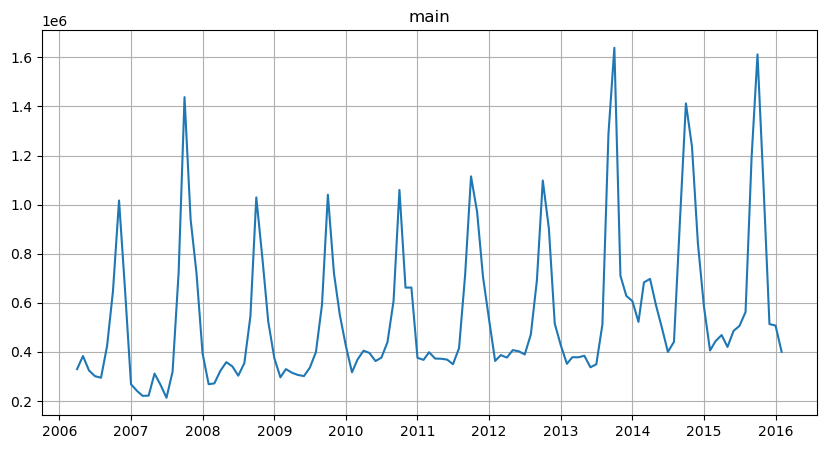

In [20]:
ts_etna.plot()

In [21]:
# split train and test
test_size = 0.15
# split_index = math.ceil(len(ts_etna.index.to_list())*(1-test_size))
HORIZON = math.ceil(len(ts_etna.index.to_list())*test_size)
train_ts, test_ts = ts_etna.train_test_split(test_size=HORIZON)
print(f'Total count of timestams is {len(ts_etna.index.to_list())}.\nNumber of train timestamps is {len(train_ts.index)} and number of test timestamps is {len(test_ts.index)}')


HORIZON_2 = math.ceil(len(ts_etna_2.index.to_list())*test_size)
train_ts_2, test_ts_2 = ts_etna_2.train_test_split(test_size=HORIZON_2)
print(f'Total count of timestams is {len(ts_etna_2.index.to_list())}.\nNumber of train timestamps is {len(train_ts_2.index)} and number of test timestamps is {len(test_ts_2.index)}')

Total count of timestams is 119.
Number of train timestamps is 101 and number of test timestamps is 18
Total count of timestams is 146.
Number of train timestamps is 124 and number of test timestamps is 22


### 5.1 ETNA CatBoost Baseline

#### 5.1.1 Use dataset from previous part

In [27]:
# create addition features
# lags = LagTransform(in_column='target', lags=list(range(1, 13)), out_column='lag')
# train_ts.fit_transform([lags])
display(train_ts.info())

# declare the model and forecast interval
model_1 = CatBoostMultiSegmentModel(n_estimators=1000, learning_rate=0.01, random_seed=12345)
display(HORIZON)

# model fit
model_1.fit(train_ts)

# model forecast, future_ts is addition table for dates of forecasting values
future_ts = train_ts.make_future(future_steps=HORIZON)
forecast_ts = model_1.forecast(future_ts, HORIZON)

# check R^2 score's value
r2 = R2()

# plot result
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)
print(f"Metric R^2 equal to {r2(y_true=test_ts, y_pred=forecast_ts)['main']:.2f}")

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 8
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2006-04-01    2014-08-01     101            0


None

18

CatBoostError: Invalid loss_function='R2': for regressor use RMSE, MultiRMSE, SurvivalAft, MAE, Quantile, LogLinQuantile, Poisson, MAPE, Lq or custom objective object

In [23]:
display(train_ts.describe())
display(test_ts.describe())
display(forecast_ts.describe())

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2006-04-01,2014-08-01,101,0,1,8,0,0,MS


,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2014-09-01,2016-02-01,18,0,1,8,0,0,MS


,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2014-09-01,2016-02-01,18,0,1,8,0,0,MS


In [24]:
display(test_ts)
display(forecast_ts)

segment          main                                                         \
feature        lag_21     lag_22     lag_23     lag_24     lag_25     lag_26   
timestamp                                                                      
2014-09-01   515118.0   903459.0  1098253.0   691674.0   471034.0   389497.0   
2014-10-01   426367.0   515118.0   903459.0  1098253.0   691674.0   471034.0   
2014-11-01   351372.0   426367.0   515118.0   903459.0  1098253.0   691674.0   
2014-12-01   378399.0   351372.0   426367.0   515118.0   903459.0  1098253.0   
2015-01-01   377960.0   378399.0   351372.0   426367.0   515118.0   903459.0   
2015-02-01   384205.0   377960.0   378399.0   351372.0   426367.0   515118.0   
2015-03-01   337186.0   384205.0   377960.0   378399.0   351372.0   426367.0   
2015-04-01   349474.0   337186.0   384205.0   377960.0   378399.0   351372.0   
2015-05-01   511174.0   349474.0   337186.0   384205.0   377960.0   378399.0   
2015-06-01  1289187.0   511174.0   349474.0   337186.0   384205.0   377960.0   
2015-07-01  1639032.0  1289187.0   511174.0   349474.0   337186.0   384205.0   
2015-08-01   710266.0  1639032.0  1289187.0   511174.0   349474.0   337186.0   
2015-09-01   628220.0   710266.0  1639032.0  1289187.0   511174.0   349474.0   
2015-10-01   606710.0   628220.0   710266.0  1639032.0  1289187.0   511174.0   
2015-11-01   522132.0   606710.0   628220.0   710266.0  1639032.0  1289187.0   
2015-12-01   683236.0   522132.0   606710.0   628220.0   710266.0  1639032.0   
2016-01-01   697423.0   683236.0   522132.0   606710.0   628220.0   710266.0   
2016-02-01   591250.0   697423.0   683236.0   522132.0   606710.0   628220.0   

segment                                       
feature        lag_27     month_avg   target  
timestamp                                     
2014-09-01   402256.0  7.723670e+05   941818  
2014-10-01   389497.0  1.209193e+06  1412686  
2014-11-01   471034.0  9.013001e+05  1235389  
2014-12-01   691674.0  6.321834e+05   842653  
2015-01-01  1098253.0  4.491685e+05   583681  
2015-02-01   903459.0  3.532077e+05   405716  
2015-03-01   515118.0  3.868298e+05   443687  
2015-04-01   426367.0  3.887501e+05   468522  
2015-05-01   351372.0  3.929136e+05   420072  
2015-06-01   378399.0  3.683559e+05   485652  
2015-07-01   377960.0  3.523422e+05   505717  
2015-08-01   384205.0  4.206615e+05   562187  
2015-09-01   337186.0  7.723670e+05  1194608  
2015-10-01   349474.0  1.209193e+06  1612160  
2015-11-01   511174.0  9.013001e+05  1071872  
2015-12-01  1289187.0  6.321834e+05   513186  
2016-01-01  1639032.0  4.491685e+05   507223  
2016-02-01   710266.0  3.532077e+05   400359

segment      main                                                      \
feature    lag_21 lag_22 lag_23 lag_24 lag_25 lag_26 lag_27 month_avg   
timestamp                                                               
2014-09-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2014-10-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2014-11-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2014-12-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-01-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-02-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-03-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-04-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-05-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-06-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-07-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-08-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-09-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-10-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-11-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2015-12-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2016-01-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2016-02-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   

segment                                                                    \
feature            target target_component_lag_21 target_component_lag_22   
timestamp                                                                   
2014-09-01  343626.330311            57915.841156            49641.921322   
2014-10-01  343626.330311            57915.841156            49641.921322   
2014-11-01  343626.330311            57915.841156            49641.921322   
2014-12-01  343626.330311            57915.841156            49641.921322   
2015-01-01  343626.330311            57915.841156            49641.921322   
2015-02-01  343626.330311            57915.841156            49641.921322   
2015-03-01  343626.330311            57915.841156            49641.921322   
2015-04-01  343626.330311            57915.841156            49641.921322   
2015-05-01  343626.330311            57915.841156            49641.921322   
2015-06-01  343626.330311            57915.841156            49641.921322   
2015-07-01  343626.330311            57915.841156            49641.921322   
2015-08-01  343626.330311            57915.841156            49641.921322   
2015-09-01  343626.330311            57915.841156            49641.921322   
2015-10-01  343626.330311            57915.841156            49641.921322   
2015-11-01  343626.330311            57915.841156            49641.921322   
2015-12-01  343626.330311            57915.841156            49641.921322   
2016-01-01  343626.330311            57915.841156            49641.921322   
2016-02-01  343626.330311            57915.841156            49641.921322   

segment                                                     \
feature    target_component_lag_23 target_component_lag_24   
timestamp                                                    
2014-09-01             16200.11007            11526.152012   
2014-10-01             16200.11007            11526.152012   
2014-11-01             16200.11007            11526.152012   
2014-12-01             16200.11007            11526.152012   
2015-01-01             16200.11007            11526.152012   
2015-02-01             16200.11007            11526.152012   
2015-03-01             16200.11007            11526.152012   
2015-04-01             16200.11007            11526.152012   
2015-05-01             16200.11007            11526.152012   
2015-06-01             16200.11007            11526.152012   
2015-07-01             16200.11007        